#!/usr/bin/env python3
# unilag_lstm_forecast_multi_feeder.py
#
# 1. Read historic Jun-2024 → Jun-2025 excel
# 2. Scale it with academic calendar
# 3. Train LSTM models for each feeder (past-24h → next-h)
# 4. Roll 8760h from 2025-06-02 00:00 for each feeder
# 5. Sum feeder predictions for total load
# 6. Save forecasts + sanity plots
# ---------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pathlib
import sys
import os

-------------- CONFIG --------------------------------------------------

In [ ]:

SOURCE_XLS = "/content/drive/MyDrive/Project References/unilag_load_profile.xlsx"
OUT_CSV    = "unilag_LSTM_8760h_forecast_Jun2025_Jun2026_NEW.csv"
OUT_PNG    = "lstm_forecast_plots.png"

LOOKBACK    = 24          # hours
FORECAST_H  = 8760        # 1 year
EPOCHS      = 50
BATCH       = 64
START_FCST  = pd.Timestamp("2025-06-02 00:00")   # first forecast step

-------------- HELPERS -------------------------------------------------

In [ ]:
def academic_scale(ts):
    """Return scaling factor 1.0 (session) or 0.6 (break) per your calendar."""
    y = ts.year
    d = ts.date()
    # permanent month-level: May & long vacation
    if dt.date(y,4,15) <= d <= dt.date(y,5,15):
        return 0.8         # May + first half June
    if dt.date(y,9,16) <= d <= dt.date(y,11,14):
        return 0.6          # long vacation
    if dt.date(y,12,21) <= d <= dt.date(y,12,31):
        return 0.6          # Xmas
    return 1.0


In [ ]:
def add_calendar(df):
    """append month / weekday / hour and cyclic sin/cos"""
    out = df.copy()
    idx = out.index
    out["m"]  = idx.month   / 12
    out["wd"] = idx.dayofweek / 6
    out["h"]  = idx.hour    / 23
    out["holiday"] = idx.map(lambda t: 1. - academic_scale(t))
    out["m_sin"] = np.sin(2*np.pi*idx.month/12)
    out["m_cos"] = np.cos(2*np.pi*idx.month/12)
    out["h_sin"] = np.sin(2*np.pi*idx.hour /24)
    out["h_cos"] = np.cos(2*np.pi*idx.hour /24)
    return out

In [ ]:
def prepare_supervised_data(hist_df, target_col):
    """Prepare supervised learning data for a specific target column"""
    X, y = [], []
    feat_cols = hist_df.columns.drop(target_col)

    for i in range(LOOKBACK, len(hist_df)):
        seq = hist_df[target_col].iloc[i-LOOKBACK:i].values.reshape(-1, 1)  # (24,1)
        cal = hist_df[feat_cols].iloc[i].values
        X.append(np.hstack([seq, np.tile(cal, (LOOKBACK, 1))]))
        y.append(hist_df[target_col].iloc[i])

    return np.array(X), np.array(y)

In [ ]:
def build_lstm_model(input_shape):
    """Build and compile LSTM model"""
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=['mae'])
    return model

In [ ]:
def scale_load_column(X, scaler):
    """Scale only the load column (first column) of the input data"""
    out = X.copy()
    batch_size, seq_len, n_features = out.shape

    # Extract load column, scale it, then put it back
    load_col = out[:, :, 0].reshape(-1, 1)
    scaled_load = scaler.transform(load_col)
    out[:, :, 0] = scaled_load.reshape(batch_size, seq_len)

    return out

In [ ]:
def generate_forecast(model, scaler, hist_window, start_time, forecast_hours):
    """Generate multi-step forecast using the trained model"""
    preds, tlist = [], []
    current = start_time

    for i in range(forecast_hours):
        if i % 1000 == 0:
            print(f"  Progress: {i}/{forecast_hours} hours")

        # Calculate calendar features for current timestamp
        cal = [
            current.month / 12,
            current.dayofweek / 6,
            current.hour / 23,
            1 - academic_scale(current),
            np.sin(2 * np.pi * current.month / 12),
            np.cos(2 * np.pi * current.month / 12),
            np.sin(2 * np.pi * current.hour / 24),
            np.cos(2 * np.pi * current.hour / 24),
        ]

        # Create input sequence
        Xin = np.hstack([hist_window, np.tile(cal, (LOOKBACK, 1))]).reshape(1, LOOKBACK, -1)

        # Scale the load column
        Xin_scaled = scale_load_column(Xin, scaler)

        # Make prediction
        pred_scaled = model.predict(Xin_scaled, verbose=0)
        pred = scaler.inverse_transform(pred_scaled).ravel()[0]

        # Ensure prediction is positive
        pred = max(0, pred)

        # Store results
        preds.append(pred)
        tlist.append(current)

        # Update sliding window
        hist_window = np.roll(hist_window, -1, axis=0)
        hist_window[-1, 0] = pred

        # Move to next hour
        current += pd.Timedelta(hours=1)

    return pd.DataFrame({"Timestamp": tlist, "Forecast": preds})

-------------- 1. LOAD & PREP HISTORIC DATA --------------------------------

In [ ]:
raw = pd.read_excel(SOURCE_XLS, parse_dates=[0])

In [ ]:
# Rename first column to Timestamp
df = pd.read_excel('/content/drive/MyDrive/Books/unilag_profile_load_Jun2024_Jun2025.xlsx', sheet_name='Sheet1')
raw.rename(columns={raw.columns[0]: "Timestamp"}, inplace=True)
raw.set_index("Timestamp", inplace=True)

print(f"Loaded data shape: {raw.shape}")
print(f"Date range: {raw.index.min()} to {raw.index.max()}")
print("Available columns:", raw.columns.tolist())

Loaded data shape: (8784, 13)
Date range: 2024-06-01 00:00:00 to 2025-06-01 23:00:00
Available columns: ['PHCN_A_amps', 'Feeder1', 'Feeder9', 'Feeder4', 'Feeder3', 'Feeder2', 'PHCN_B_amps', 'Feeder8', 'Feeder7', 'Feeder6', 'Feeder5', 'Service_Area', 'Total_MW']


In [ ]:
# Identify feeder columns (all columns except PHCN and Total)
feeder_cols = [col for col in raw.columns if 'Feeder' in col or 'PHCN' in col or 'Service' in col]
print(f"Identified feeder columns: {feeder_cols}")

Identified feeder columns: ['PHCN_A_amps', 'Feeder1', 'Feeder9', 'Feeder4', 'Feeder3', 'Feeder2', 'PHCN_B_amps', 'Feeder8', 'Feeder7', 'Feeder6', 'Feeder5', 'Service_Area']


In [ ]:
# Create continuous hourly grid for each feeder
print("Creating continuous hourly time series for each feeder...")
feeder_dfs = {}
for col in feeder_cols:
    # Clean and prepare each feeder's data
    feeder_series = raw[col].sort_index().asfreq("H").interpolate(method='linear')

    # Apply academic calendar scaling
    feeder_scaled = feeder_series * feeder_series.index.map(academic_scale)

    # Add calendar features
    feeder_df = add_calendar(feeder_scaled.to_frame(col))
    feeder_dfs[col] = feeder_df.loc[: START_FCST - pd.Timedelta(hours=1)]  # only history

Creating continuous hourly time series for each feeder...


/tmp/ipython-input-1205008843.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  feeder_series = raw[col].sort_index().asfreq("H").interpolate(method='linear')
/tmp/ipython-input-1205008843.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  feeder_series = raw[col].sort_index().asfreq("H").interpolate(method='linear')
/tmp/ipython-input-1205008843.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  feeder_series = raw[col].sort_index().asfreq("H").interpolate(method='linear')
/tmp/ipython-input-1205008843.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  feeder_series = raw[col].sort_index().asfreq("H").interpolate(method='linear')
/tmp/ipython-input-1205008843.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  feed

-------------- 2. TRAIN MODELS FOR EACH FEEDER ------------------------

In [ ]:
print("\nTraining models for each feeder...")
models = {}
scalers = {}
test_results = {}

for feeder_name, hist_df in feeder_dfs.items():
    print(f"\nProcessing feeder: {feeder_name}")

    # Prepare supervised data
    X, y = prepare_supervised_data(hist_df, feeder_name)

    # Split data
    split = int(0.8 * len(X))
    Xtr, Xte, ytr, yte = X[:split], X[split:], y[:split], y[split:]

    # Scale only the load column (first column)
    scaler = MinMaxScaler()
    load_data_for_fitting = Xtr[:, :, 0].reshape(-1, 1)
    scaler.fit(load_data_for_fitting)

    # Scale training and test data
    Xtr_s = scale_load_column(Xtr, scaler)
    Xte_s = scale_load_column(Xte, scaler)
    ytr_s = scaler.transform(ytr.reshape(-1, 1)).ravel()

    # Build and train model
    model = build_lstm_model((LOOKBACK, X.shape[2]))

    print(f"Training model for {feeder_name}...")
    history = model.fit(
        Xtr_s, ytr_s,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate model
    ypred_scaled = model.predict(Xte_s, verbose=0)
    ypred = scaler.inverse_transform(ypred_scaled).ravel()

    mae = mean_absolute_error(yte, ypred)
    rmse = np.sqrt(mean_squared_error(yte, ypred))

    print(f"Test Set Performance for {feeder_name}:")
    print(f"  MAE: {mae:.2f} MW")
    print(f"  RMSE: {rmse:.2f} MW")
    print(f"  MAPE: {np.mean(np.abs((yte - ypred) / (yte + 1e-6))) * 100:.2f}%")

    # Store model and results
    models[feeder_name] = model
    scalers[feeder_name] = scaler
    test_results[feeder_name] = {
        'actual': yte,
        'predicted': ypred,
        'timestamps': hist_df.index[split + LOOKBACK:]
    }



Training models for each feeder...

Processing feeder: PHCN_A_amps
Training model for PHCN_A_amps...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0820 - mae: 0.1846 - val_loss: 0.0026 - val_mae: 0.0405
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - mae: 0.0302 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.9740e-04 - mae: 0.0240 - val_loss: 0.0015 - val_mae: 0.0315
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.4375e-04 - mae: 0.0228 - val_loss: 0.0013 - val_mae: 0.0287
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8.5048e-04 - mae: 0.0218 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.6063e-04 - mae: 0.0218 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.2925e-04 - mae: 0.0200 - val_loss: 0.0010 - val_mae: 0.0258
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0328 - mae: 0.1226 - val_loss: 0.0044 - val_mae: 0.0528
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0022 - mae: 0.0352 - val_loss: 0.0026 - val_mae: 0.0401
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0028 - val_mae: 0.0405
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0018 - mae: 0.0313 - val_loss: 0.0031 - val_mae: 0.0429
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0017 - mae: 0.0305 - val_loss: 0.0023 - val_mae: 0.0358
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019 - mae: 0.0322 - val_loss: 0.0020 - val_mae: 0.0350
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0027 - val_mae: 0.0389
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0021 - val_mae: 0.0343
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0356 - mae: 0.1244 - val_loss: 0.0028 - val_mae: 0.0412
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0032 - val_mae: 0.0433
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0019 - mae: 0.0318 - val_loss: 0.0027 - val_mae: 0.0389
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0019 - mae: 0.0321 - val_loss: 0.0022 - val_mae: 0.0363
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0018 - mae: 0.0314 - val_loss: 0.0021 - val_mae: 0.0345
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0020 - val_mae: 0.0347
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0023 - val_mae: 0.0362
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0030 - val_mae: 0.0434
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0462 - mae: 0.1373 - val_loss: 0.0037 - val_mae: 0.0463
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0322 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 0.0021 - val_mae: 0.0347
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0019 - val_mae: 0.0335
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0021 - val_mae: 0.0334
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0025 - val_mae: 0.0408
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0014 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0228 - mae: 0.0956 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 0.0019 - val_mae: 0.0330
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0031 - val_mae: 0.0430
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - mae: 0.0275 - val_loss: 0.0020 - val_mae: 0.0342
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0018 - val_mae: 0.0322
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014 - mae: 0.0277 - val_loss: 0.0017 - val_mae: 0.0308
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0018 - val_mae: 0.0316
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0279 - mae: 0.1133 - val_loss: 0.0048 - val_mae: 0.0503
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - mae: 0.0388 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - mae: 0.0355 - val_loss: 0.0033 - val_mae: 0.0433
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0024 - mae: 0.0353 - val_loss: 0.0028 - val_mae: 0.0405
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0032 - val_mae: 0.0446
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0019 - mae: 0.0316 - val_loss: 0.0027 - val_mae: 0.0398
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018 - mae: 0.0314 - val_loss: 0.0024 - val_mae: 0.0379
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0026 - val_mae: 0.0395
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0697 - mae: 0.1698 - val_loss: 0.0026 - val_mae: 0.0396
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 0.0021 - val_mae: 0.0372
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011 - mae: 0.0251 - val_loss: 0.0016 - val_mae: 0.0330
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 0.0019 - val_mae: 0.0348
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010 - mae: 0.0234 - val_loss: 9.5706e-04 - val_mae: 0.0242
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.7855e-04 - mae: 0.0222 - val_loss: 8.7056e-04 - val_mae: 0.0224
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.7242e-04 - mae: 0.0217 - val_loss: 8.6743e-04 - val_mae: 0.0223
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3746e-04 - mae: 0.0199 - val_loss: 8.8013e-04 - val_mae: 0.0223
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0364 - mae: 0.1224 - val_loss: 0.0039 - val_mae: 0.0510
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0018 - mae: 0.0317 - val_loss: 0.0026 - val_mae: 0.0400
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0015 - mae: 0.0290 - val_loss: 0.0019 - val_mae: 0.0334
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0015 - mae: 0.0286 - val_loss: 0.0022 - val_mae: 0.0366
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 0.0020 - val_mae: 0.0348
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0378
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0013 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0770 - mae: 0.1768 - val_loss: 0.0029 - val_mae: 0.0437
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - mae: 0.0344 - val_loss: 0.0024 - val_mae: 0.0383
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - mae: 0.0332 - val_loss: 0.0025 - val_mae: 0.0371
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0020 - mae: 0.0307 - val_loss: 0.0021 - val_mae: 0.0345
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0021 - mae: 0.0312 - val_loss: 0.0020 - val_mae: 0.0340
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0020 - val_mae: 0.0338
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0337
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017 - mae: 0.0292 - val_loss: 0.0019 - val_mae: 0.0330
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0262 - mae: 0.1072 - val_loss: 0.0027 - val_mae: 0.0414
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0038 - val_mae: 0.0473
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018 - mae: 0.0309 - val_loss: 0.0035 - val_mae: 0.0467
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0017 - mae: 0.0305 - val_loss: 0.0023 - val_mae: 0.0371
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 0.0024 - val_mae: 0.0388
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0029 - val_mae: 0.0421
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0021 - val_mae: 0.0368
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0025 - val_mae: 0.0400
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0485 - mae: 0.1481 - val_loss: 0.0046 - val_mae: 0.0529
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022 - mae: 0.0349 - val_loss: 0.0028 - val_mae: 0.0399
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0024 - val_mae: 0.0378
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0029 - val_mae: 0.0417
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0018 - mae: 0.0316 - val_loss: 0.0027 - val_mae: 0.0387
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0017 - mae: 0.0299 - val_loss: 0.0027 - val_mae: 0.0412
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0017 - mae: 0.0306 - val_loss: 0.0020 - val_mae: 0.0347
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 0.0020 - val_mae: 0.0344
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0017 - mae: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0837 - mae: 0.1873 - val_loss: 0.0027 - val_mae: 0.0397
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022 - mae: 0.0358 - val_loss: 0.0025 - val_mae: 0.0380
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0019 - mae: 0.0322 - val_loss: 0.0021 - val_mae: 0.0344
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 0.0025 - val_mae: 0.0383
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0017 - mae: 0.0302 - val_loss: 0.0019 - val_mae: 0.0331
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0018 - val_mae: 0.0324
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0015 - mae: 0.

-------------- 3. GENERATE FORECASTS FOR EACH FEEDER ------------------

In [ ]:
print("\nGenerating forecasts for each feeder...")
feeder_forecasts = {}

for feeder_name in feeder_dfs.keys():
    print(f"\nGenerating forecast for {feeder_name}")

    # Initialize with last 24 hours of historical data
    hist_window = feeder_dfs[feeder_name][feeder_name].iloc[-LOOKBACK:].values.reshape(-1, 1)

    # Generate forecast
    fcst_df = generate_forecast(
        models[feeder_name],
        scalers[feeder_name],
        hist_window,
        START_FCST,
        FORECAST_H
    )

    # Store forecast
    fcst_df.rename(columns={"Forecast": feeder_name}, inplace=True)
    feeder_forecasts[feeder_name] = fcst_df


Generating forecasts for each feeder...

Generating forecast for PHCN_A_amps
  Progress: 0/8760 hours
  Progress: 1000/8760 hours
  Progress: 2000/8760 hours
  Progress: 3000/8760 hours
  Progress: 4000/8760 hours
  Progress: 5000/8760 hours
  Progress: 6000/8760 hours
  Progress: 7000/8760 hours
  Progress: 8000/8760 hours

Generating forecast for Feeder1
  Progress: 0/8760 hours
  Progress: 1000/8760 hours
  Progress: 2000/8760 hours
  Progress: 3000/8760 hours
  Progress: 4000/8760 hours
  Progress: 5000/8760 hours
  Progress: 6000/8760 hours
  Progress: 7000/8760 hours
  Progress: 8000/8760 hours

Generating forecast for Feeder9
  Progress: 0/8760 hours
  Progress: 1000/8760 hours
  Progress: 2000/8760 hours
  Progress: 3000/8760 hours
  Progress: 4000/8760 hours
  Progress: 5000/8760 hours
  Progress: 6000/8760 hours
  Progress: 7000/8760 hours
  Progress: 8000/8760 hours

Generating forecast for Feeder4
  Progress: 0/8760 hours
  Progress: 1000/8760 hours
  Progress: 2000/8760 h

In [ ]:
# Combine all feeder forecasts into one DataFrame
all_forecasts = pd.DataFrame({"Timestamp": feeder_forecasts[next(iter(feeder_forecasts))]["Timestamp"]})
for feeder_name, fcst_df in feeder_forecasts.items():
    all_forecasts[feeder_name] = fcst_df[feeder_name]

In [ ]:
# Calculate total forecast
all_forecasts["Total_MW"] = all_forecasts.drop("Timestamp", axis=1).sum(axis=1)

In [ ]:
# Save forecasts
all_forecasts.to_csv(OUT_CSV, index=False)
print(f"\nAll forecasts saved to {OUT_CSV}")


All forecasts saved to unilag_LSTM_8760h_forecast_Jun2025_Jun2026_NEW.csv


-------------- 4. VISUALIZATION ---------------------------------------

In [ ]:
plt.figure(figsize=(15, 18))

<Figure size 1500x1800 with 0 Axes>

<Figure size 1500x1800 with 0 Axes>

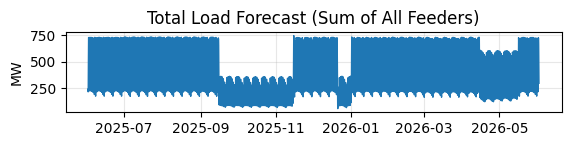

In [ ]:
# Plot 1: Total forecast
plt.subplot(4, 1, 1)
plt.plot(all_forecasts["Timestamp"], all_forecasts["Total_MW"], lw=1)
plt.title("Total Load Forecast (Sum of All Feeders)")
plt.ylabel("MW")
plt.grid(True, alpha=0.3)
plt.show()

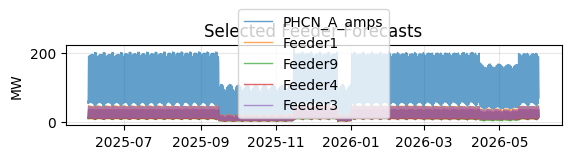

In [ ]:
# Plot 2: Individual feeder forecasts (first 5 for clarity)
plt.subplot(4, 1, 2)
for i, feeder_name in enumerate(list(feeder_forecasts.keys())[:5]):
    plt.plot(all_forecasts["Timestamp"], all_forecasts[feeder_name],
             label=feeder_name, alpha=0.7, lw=1)
plt.title("Selected Feeder Forecasts")
plt.ylabel("MW")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-4106902095.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hist_monthly = raw['Total_MW'].resample("M").mean()
/tmp/ipython-input-4106902095.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fcst_monthly = all_forecasts.set_index("Timestamp")["Total_MW"].resample("M").mean()


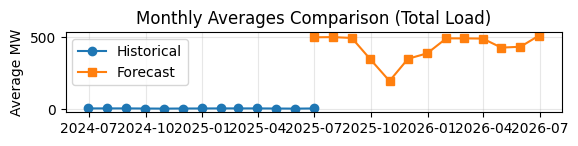

In [ ]:
# Plot 3: Monthly averages comparison for total load
plt.subplot(4, 1, 3)
if 'Total_MW' in raw.columns:
    hist_monthly = raw['Total_MW'].resample("M").mean()
else:
    # Calculate historical total from feeders
    hist_total = raw[feeder_cols].sum(axis=1)
    hist_monthly = hist_total.resample("M").mean()

fcst_monthly = all_forecasts.set_index("Timestamp")["Total_MW"].resample("M").mean()
plt.plot(hist_monthly.index, hist_monthly, "o-", label="Historical", markersize=6)
plt.plot(fcst_monthly.index, fcst_monthly, "s-", label="Forecast", markersize=6)
plt.ylabel("Average MW")
plt.title("Monthly Averages Comparison (Total Load)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

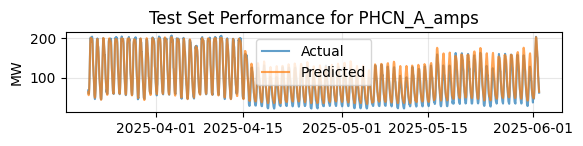

In [ ]:
# Plot 4: Test set performance for one feeder (example)
plt.subplot(4, 1, 4)
example_feeder = list(test_results.keys())[0]
result = test_results[example_feeder]
plt.plot(result['timestamps'], result['actual'], label="Actual", alpha=0.7)
plt.plot(result['timestamps'], result['predicted'], label="Predicted", alpha=0.7)
plt.title(f"Test Set Performance for {example_feeder}")
plt.ylabel("MW")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches='tight')
print(f"Plots saved to {OUT_PNG}")

Plots saved to lstm_forecast_plots.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Show summary statistics
print("\nForecast Summary:")
print(f"  Average total load: {all_forecasts['Total_MW'].mean():.2f} MW")
print(f"  Peak total load: {all_forecasts['Total_MW'].max():.2f} MW")
print(f"  Minimum total load: {all_forecasts['Total_MW'].min():.2f} MW")
print(f"  Total energy: {all_forecasts['Total_MW'].sum():.0f} MWh")


Forecast Summary:
  Average total load: 422.70 MW
  Peak total load: 747.79 MW
  Minimum total load: 51.08 MW
  Total energy: 3702823 MWh


In [ ]:
print("\nFeeder-specific statistics:")
for feeder_name in feeder_forecasts.keys():
    fcst = all_forecasts[feeder_name]
    print(f"\n{feeder_name}:")
    print(f"  Average: {fcst.mean():.2f} MW")
    print(f"  Peak: {fcst.max():.2f} MW")
    print(f"  Min: {fcst.min():.2f} MW")
    print(f"  Contribution: {(fcst.mean() / all_forecasts['Total_MW'].mean()) * 100:.1f}% of total")

plt.show()
print("\nScript completed successfully!")


Feeder-specific statistics:

PHCN_A_amps:
  Average: 114.11 MW
  Peak: 213.02 MW
  Min: 12.30 MW
  Contribution: 27.0% of total

Feeder1:
  Average: 25.90 MW
  Peak: 47.10 MW
  Min: 1.54 MW
  Contribution: 6.1% of total

Feeder9:
  Average: 19.20 MW
  Peak: 34.65 MW
  Min: 2.64 MW
  Contribution: 4.5% of total

Feeder4:
  Average: 20.80 MW
  Peak: 37.23 MW
  Min: 2.71 MW
  Contribution: 4.9% of total

Feeder3:
  Average: 25.27 MW
  Peak: 45.82 MW
  Min: 2.83 MW
  Contribution: 6.0% of total

Feeder2:
  Average: 23.63 MW
  Peak: 43.21 MW
  Min: 2.76 MW
  Contribution: 5.6% of total

PHCN_B_amps:
  Average: 96.65 MW
  Peak: 172.99 MW
  Min: 8.10 MW
  Contribution: 22.9% of total

Feeder8:
  Average: 24.45 MW
  Peak: 42.87 MW
  Min: 3.71 MW
  Contribution: 5.8% of total

Feeder7:
  Average: 22.19 MW
  Peak: 39.51 MW
  Min: 4.15 MW
  Contribution: 5.2% of total

Feeder6:
  Average: 17.21 MW
  Peak: 30.54 MW
  Min: 2.62 MW
  Contribution: 4.1% of total

Feeder5:
  Average: 18.23 MW
  Peak: